<h1><b>Comprehensive Code Notebook for the IDCA Task</b></h1>


<p>To perform advanced spatial analysis, statistical modeling, and data visualization, the following libraries have been imported and utilized:</p>

2><h<2>Imported Libraries - Quick Not</b>es</h2>

<ol>
  <li><strong>numpy (np)</strong>: Provides support for large, multi-dimensional arrays and matrices, along with mathematical functions to operate on these arrays.</li>

  <li><strong>pandas (pd)</strong>: Offers data manipulation and analysis tools, especially for structured data (DataFrames and Series).</li>

  <li><strong>geopandas (gpd)</strong>: Extends pandas to handle spatial data and operations, enabling geographic data processing.</li>

  <li><strong>libpysal (lps)</strong>: A library for spatial data analysis, including spatial weights construction and regionalization.</li>

  <li><strong>esda</strong>: Provides statistical tools for exploratory spatial data analysis (e.g., spatial autocorrelation metrics).</li>

  <li><strong>matplotlib.pyplot (plt)</strong>: A popular plotting library for creating static, interactive, and animated visualizations.</li>

  <li><strong>mapclassify (mc)</strong>: Used for classifying geographic data for mapping, including various classification schemes.</li>

  <li><strong>sklearn.preprocessing (MinMaxScaler)</strong>: Scales features to a specified range (e.g., 0 to 1) for normalization.</li>

  <li><strong>seaborn (sns)</strong>: Statistical data visualization library built on matplotlib, offering enhanced aesthetic and informative plots.</li>

  <li><strong>scipy.stats (zscore, stats)</strong>: Provides statistical functions and tests, including z-score calculations and other statistical utilities.</li>

  <li><strong>statsmodels.discrete.discrete_model (Logit)</strong>: Implements logistic regression for binary outcome modeling.</li>

  <li><strong>statsmodels.tools (add_constant)</strong>: Adds a constant column to an array, often required for regression models.</li>

  <li><strong>statsmodels.stats.outliers_influence (variance_inflation_factor)</strong>: Computes VIF to detect multicollinearity in regression models.</li>

  <li><strong>esda.G_Local</strong>: Calculates local versions of spatial autocorrelation statistics (e.g., Getis-Ord G*).</li>

  <li><strong>libpysal.weights (KNN)</strong>: Constructs K-nearest neighbor spatial weights matrices.</li>

  <li><strong>statsmodels.api (sm)</strong>: Provides access to various statistical models, tests, and data exploration functions.</li>

  <li><strong>statsmodels.formula.api (smf)</strong>: Enables statistical modeling using R-style formulas.</li>

  <li><strong>esda.moran (Moran)</strong>: Computes Moran's I statistic for measuring spatial autocorrelation.</li>
</ol>



In [95]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as lps
import esda
import matplotlib.pyplot as plt
import mapclassify as mc
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import zscore
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from esda import G_Local
from libpysal.weights import KNN
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from esda.moran import Moran

<p><strong>Loading the Dataset:</strong> The dataset is stored in a GeoJSON file named <code>climate_health_anonymized_dataset_v4.geojson</code>. It is loaded into a GeoDataFrame using <code>geopandas.read_file()</code>, enabling spatial data analysis and visualization.</p>


In [4]:
# Load the dataset
file_path = "climate_health_anonymized_dataset_v4.geojson"
gdf = gpd.read_file(file_path)

<h1><b>TASK 1: LISA ANALYSIS ON HEART DISEASE CASES</b></h1>

**Selecting Relevant Columns:** A new DataFrame, `heart_df`, is created by extracting the `region_id`, `heart_disease_cases`, and `geometry` columns from the original GeoDataFrame. Missing values are removed using `dropna()` to ensure clean data for analysis.


In [8]:
# Selecting relevant columns
heart_df = gdf[['region_id', 'heart_disease_cases', 'geometry']]
heart_df = heart_df.dropna()

**Creating Spatial Weights Matrix:** A **Rook** contiguity-based spatial weights matrix is generated from the `heart_df` DataFrame using `libpysal`. This matrix defines spatial relationships where regions sharing an edge are considered neighbors. The `transform = 'r'` step standardizes the weights by row, ensuring they sum to 1 for each observation.


In [9]:
w = lps.weights.Rook.from_dataframe(heart_df)
w.transform = 'r'

C:\Users\SHALVI_SINGH\AppData\Local\Temp\ipykernel_20380\2112244794.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Rook.from_dataframe(heart_df)
C:\Users\SHALVI_SINGH\anaconda3\Lib\site-packages\libpysal\weights\contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


**Global Moran's I:** This calculates **Moran's I**, a measure of spatial autocorrelation, using heart disease cases and the spatial weights matrix `w`. A positive value indicates clustering, while a negative value suggests dispersion. The `p-value` assesses the statistical significance of the observed spatial pattern. The results are printed with four decimal precision.


In [107]:
# Global Moran's I
moran = esda.Moran(heart_df['heart_disease_cases'], w)
print("\n--- Global Moran's I ---\n")
print(f"Moran's I: {moran.I:.4f}, p-value: {moran.p_sim:.4f}")


--- Global Moran's I ---

Moran's I: -0.0017, p-value: 0.2830


**Local Moran's I (LISA):** This computes **Local Indicators of Spatial Association (LISA)** to identify spatial clusters and outliers in heart disease cases. 

- `LISA_I`: Stores the local Moran's I value for each region.
- `LISA_p`: Contains the simulated p-values to assess statistical significance.
- `LISA_cluster`: Indicates the cluster type (e.g., High-High, Low-Low, etc.) based on quadrant values.

These metrics help detect localized patterns of spatial autocorrelation.


In [11]:
# Local Moran's I (LISA)
lm = esda.Moran_Local(heart_df['heart_disease_cases'], w)
heart_df['LISA_I'] = lm.Is
heart_df['LISA_p'] = lm.p_sim
heart_df['LISA_cluster'] = lm.q


**Defining Cluster Labels:** A dictionary of cluster labels is created to interpret the LISA cluster values:

- `1`: "HH (Hotspot)" – High values surrounded by high values.  
- `2`: "LH" – Low values surrounded by high values.  
- `3`: "LL (Cold Spot)" – Low values surrounded by low values.  
- `4`: "HL" – High values surrounded by low values.  
- `0`: "NS" – Not significant (no spatial pattern detected).  

The `map()` function assigns these descriptive labels to the `LISA_label` column in `heart_df`.


In [12]:
# Define cluster labels
labels = {
    1: "HH (Hotspot)",  # High-High
    2: "LH",  # Low-High
    3: "LL (Cold Spot)",  # Low-Low
    4: "HL",  # High-Low
    0: "NS"  # Not significant
}
heart_df['LISA_label'] = heart_df['LISA_cluster'].map(labels)


In [13]:
# Print LISA summary
print("\n--- LISA Cluster Summary ---\n")
print(heart_df[['region_id', 'heart_disease_cases', 'LISA_label']].head())



--- LISA Cluster Summary ---

   region_id  heart_disease_cases    LISA_label
0        1.0                   10  HH (Hotspot)
1        2.0                    8            LH
2        3.0                   15  HH (Hotspot)
3        4.0                    8            LH
4        5.0                   19  HH (Hotspot)


**Moran's I Scatter Plot:**  
This code computes and visualizes **Moran's I** using a scatter plot, which helps assess spatial autocorrelation:

1. **Spatial Lag Calculation:** The spatial lag of heart disease cases is computed using `lag_spatial()`, representing the average values of neighboring regions.  
   
2. **Variable Standardization:** Both the heart disease cases and their spatial lag are standardized (z-score normalization) for visualization consistency.  

3. **Moran's I Calculation:** The global Moran's I value is computed to quantify the degree of spatial clustering.  

4. **Scatter Plot Visualization:** The Moran's I scatter plot is generated using `moran_scatterplot()` to visually inspect the relationship between the standardized values and their spatial lag.  

The slope of the red line looks close to zero, suggesting weak or no spatial autocorrelation. This means heart disease cases are likely distributed randomly across space.  
rrelation.


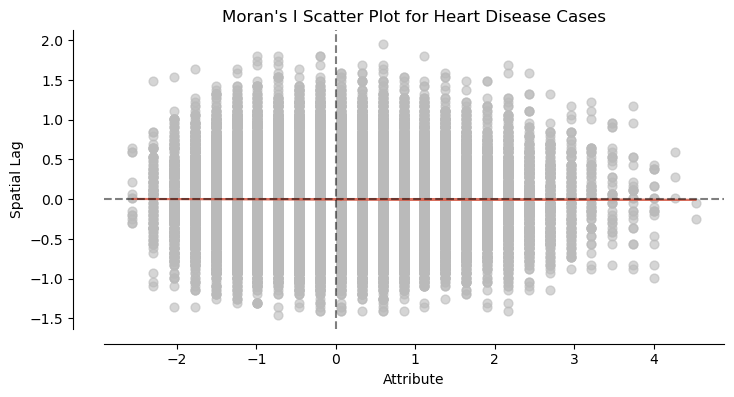

In [98]:
from splot.esda import moran_scatterplot
import esda

# Compute spatial lag
heart_df['spatial_lag'] = lps.weights.lag_spatial(w, heart_df['heart_disease_cases'])

# Standardize variables for Moran's scatter plot
heart_df['standardized_cases'] = (heart_df['heart_disease_cases'] - heart_df['heart_disease_cases'].mean()) / heart_df['heart_disease_cases'].std()
heart_df['standardized_lag'] = (heart_df['spatial_lag'] - heart_df['spatial_lag'].mean()) / heart_df['spatial_lag'].std()

# Compute Moran's I
moran = esda.Moran(heart_df['heart_disease_cases'], w)
# Plot Moran's I scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
moran_scatterplot(moran, ax=ax)
plt.title("Moran's I Scatter Plot for Heart Disease Cases")
plt.show()


**Reference Distribution of Moran’s I (KDE Plot):**  
This code visualizes the reference distribution of **Moran’s I** using a **Kernel Density Estimate (KDE)** plot:

1. **Reference Distribution:** The simulated Moran’s I values from permutation tests are displayed as a smooth KDE curve (in light blue).  
2. **Observed Moran’s I:** The observed Moran’s I value is marked by a dashed red line.  
3. **Mean of Simulated Moran’s I:** The mean of the simulated distribution is represented by a solid black line.  

This plot helps compare the observed spatial autocorrelation against a random distribution, providing insight into whether spatial patterns are statistically significant.


C:\Users\SHALVI_SINGH\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


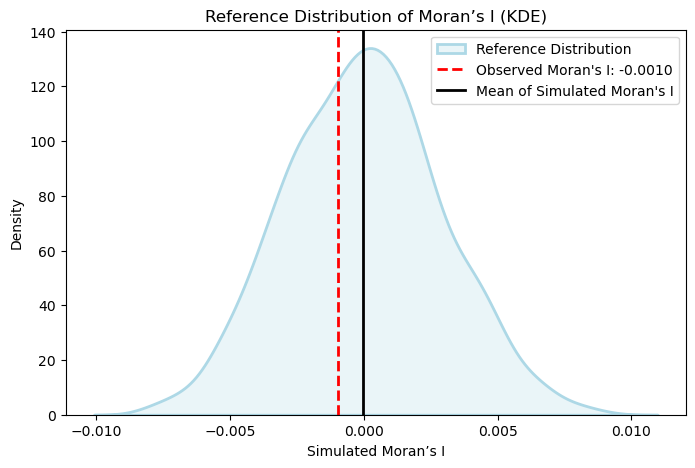

In [15]:
moran = esda.Moran(heart_df['heart_disease_cases'], w)

plt.figure(figsize=(8, 5))
sns.kdeplot(moran.sim, fill=True, color="lightblue", linewidth=2, label="Reference Distribution")
plt.axvline(moran.I, color="red", linestyle="dashed", linewidth=2, label=f"Observed Moran's I: {moran.I:.4f}")
plt.axvline(np.mean(moran.sim), color="black", linestyle="solid", linewidth=2, label="Mean of Simulated Moran's I")
plt.xlabel("Simulated Moran’s I")
plt.ylabel("Density")
plt.title("Reference Distribution of Moran’s I (KDE)")
plt.legend()
plt.show()


**LISA Cluster Map of Heart Disease Cases:**  
This code visualizes the spatial distribution of **Local Moran's I (LISA) clusters** on a geographic map:

1. **Cluster Color Mapping:** Different cluster types are assigned specific colors:
   - **Red:** High-High (Hotspot) – Areas with high values surrounded by high values.
   - **Blue:** Low-High – Areas with low values surrounded by high values.
   - **Orange:** Low-Low (Coldspot) – Areas with low values surrounded by low values.
   - **Light Blue:** High-Low – Areas with high values surrounded by low values.
   - **Gray:** Not Significant – Areas with no statistically significant spatial pattern.

2. **Mapping Clusters:** The `plot()` function visualizes the LISA clusters, using **color-coded regions** to represent each cluster type.

3. **Basemap Integration:** A contextual basemap is added using **`contextily`** to provide geographic reference.

4. **Custom Legend:** A manual legend is created to describe the LISA cluster categories.

This map helps identify and interpret spatial patterns of heart disease cases, highlighting areas with statistically significant clustering.


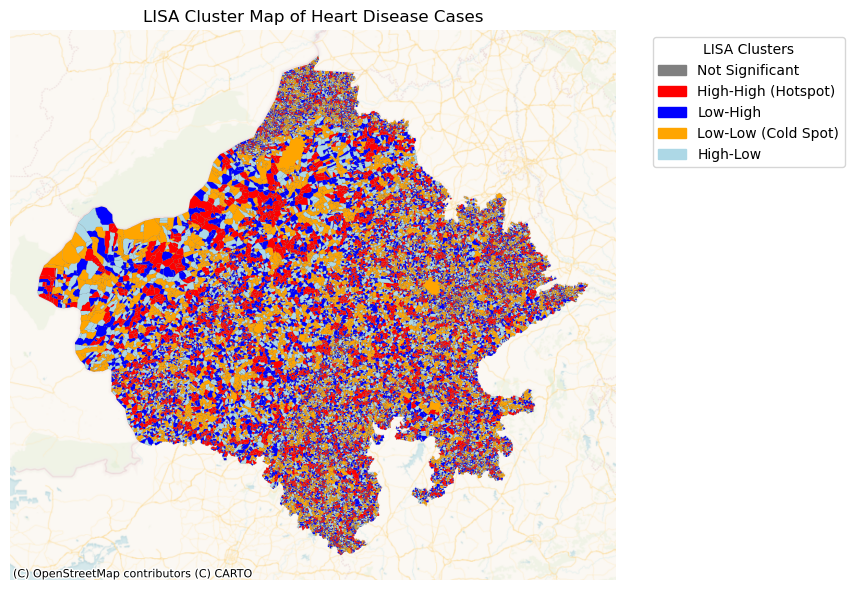

In [103]:
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define cluster color mapping
cluster_colors = {
    1: "red",       # HH (High-High) - Hotspot
    2: "blue",      # LH (Low-High)
    3: "orange",    # LL (Low-Low) - Cold Spot
    4: "lightblue", # HL (High-Low)
    0: "gray"       # NS (Not Significant)
}

# Define descriptive legend labels for each cluster
legend_labels = {
    1: "High-High (Hotspot)",
    2: "Low-High",
    3: "Low-Low (Cold Spot)",
    4: "High-Low",
    0: "Not Significant"
}

# Map LISA clusters to colors
heart_df["LISA_color"] = heart_df["LISA_cluster"].map(cluster_colors)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot classified clusters
heart_df.plot(
    color=heart_df["LISA_color"],  # Use the mapped colors
    linewidth=0.05, edgecolor="black",
    ax=ax
)

# Add basemap
ctx.add_basemap(ax, crs=heart_df.crs, source=ctx.providers.CartoDB.VoyagerNoLabels)

# Create legend patches with descriptive labels
legend_patches = [
    mpatches.Patch(color=cluster_colors[k], label=legend_labels[k]) 
    for k in sorted(cluster_colors.keys())
]

# Position the legend outside the map (to the right)
ax.legend(
    handles=legend_patches,
    title="LISA Clusters",
    loc="upper left",
    bbox_to_anchor=(1.05, 1)  # (x, y) coordinates in figure fraction
)

# Remove axes and show plot
ax.set_axis_off()
plt.title("LISA Cluster Map of Heart Disease Cases")
plt.tight_layout()
plt.show()


**Local Moran's I Clusters (Queen Contiguity):**  
This code performs the following steps:

- **Spatial Weights:**  
  A Queen contiguity spatial weights matrix is created from the GeoDataFrame `gdf` using `lps.weights.Queen.from_dataframe()`, and the weights are row-standardized (`transform = "r"`).

- **Local Moran's I Calculation:**  
  The Local Moran's I for heart disease cases is computed using `esda.Moran_Local()`, which assesses local spatial autocorrelation.

- **Cluster Categorization:**  
  Based on a significance threshold (`p_sim < 0.03`), regions are classified:
  - **High-High:** Significant regions in quadrant 1.
  - **Low-Low:** Significant regions in quadrant 2.
  - **High-Low:** Significant regions in quadrant 3.
  - **Low-High:** Significant regions in quadrant 4.
  - **Non-Significant:** Regions that do not meet the significance criteria.

- **Visualization:**  
  A custom color mapping is defined for each cluster type. The clusters are then plotted with the assigned colors, and a legend is added to indicate each cluster type.


C:\Users\SHALVI_SINGH\AppData\Local\Temp\ipykernel_20380\3091906510.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(gdf)
C:\Users\SHALVI_SINGH\anaconda3\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


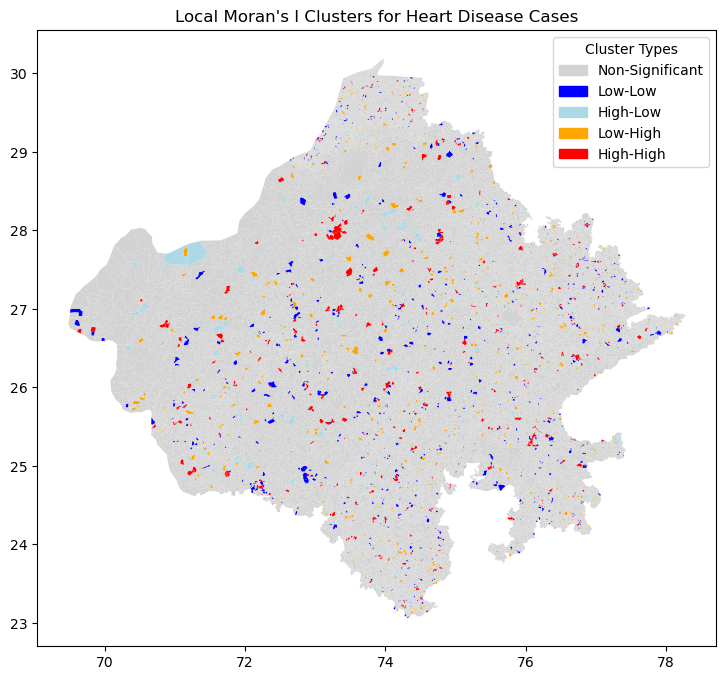

In [18]:
w = lps.weights.Queen.from_dataframe(gdf)
w.transform = "r"

# Compute Local Moran's I
local_moran = esda.Moran_Local(gdf['heart_disease_cases'], w)

# Define cluster categories
gdf['cluster'] = "Non-Significant"
sig = local_moran.p_sim < 0.03  # Significant clusters

gdf.loc[sig & (local_moran.q == 1), 'cluster'] = "High-High"
gdf.loc[sig & (local_moran.q == 2), 'cluster'] = "Low-Low"
gdf.loc[sig & (local_moran.q == 3), 'cluster'] = "High-Low"
gdf.loc[sig & (local_moran.q == 4), 'cluster'] = "Low-High"

# Define colors
cluster_colors = {
    "Non-Significant": "#D3D3D3",
    "Low-Low": "blue",
    "High-Low": "lightblue",
    "Low-High": "orange",
    "High-High": "red"
}

# Plot the clusters
fig, ax = plt.subplots(1, figsize=(10, 8))
gdf.assign(color=gdf['cluster'].map(cluster_colors)).plot(color=gdf['cluster'].map(cluster_colors), ax=ax, linewidth=0)

# Add legend
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=legend_patches, title="Cluster Types", loc="upper right")

ax.set_title("Local Moran's I Clusters for Heart Disease Cases")
plt.show()

<h1><b>TASK 2: CLIMATE HEALTH VULNERABILITY INDEX</b></h1>

**Climate Health Vulnerability Index (CHVI):**  
The CHVI is a composite metric designed to assess and rank regions based on their susceptibility to climate-related health challenges. It integrates multiple dimensions, including:

- **Exposure:** Environmental conditions (e.g., air quality, temperature, rainfall) that contribute to health risks.
- **Sensitivity:** Health indicators (e.g., rates of malnutrition, anemia, smoking) that reflect how strongly populations are affected.
- **Adaptive Capacity:** Measures of resilience (e.g., availability of rural facilities, vegetation indices) indicating a region’s ability to cope with climate impacts.

Each variable is normalized and weighted to create a single score for each region. The resulting CHVI scores help prioritize areas for intervention and resource allocation, guiding policymakers in addressing and mitigating climate-related health risks.
alth challenges.


In [19]:
# Define the CHVI components
exposure_vars = ['no2_density', 'pm25_aerosol_index', 'lst_day_celsius', 'mean_rainfall']
sensitivity_vars = ['child_malnutrition_cases', 'maternal_anemia_cases', 'smoker_cases']
adaptive_capacity_vars = ['rural_facilities', 'ndvi', 'ndwi']

In [21]:
# Normalize the data
scaler = MinMaxScaler()
gdf[exposure_vars + sensitivity_vars + adaptive_capacity_vars] = scaler.fit_transform(
    gdf[exposure_vars + sensitivity_vars + adaptive_capacity_vars]
)

**Calculating and Classifying the Climate Health Vulnerability Index (CHVI):**  
The CHVI is designed to quantify regional vulnerability to climate-related health risks. It is calculated as a weighted composite score, where:

- **Exposure** and **Sensitivity** (e.g., air pollutants, temperature, malnutrition) contribute positively to the index, and  
- **Adaptive Capacity** (e.g., facilities, vegetation indices) reduces the index.

Mathematically, the index is computed as:  
**CHVI = mean(Exposure Variables) + mean(Sensitivity Variables) - mean(Adaptive Capacity Variables)**

To interpret the CHVI, regions are classified into three vulnerability levels using quantiles of the CHVI distribution:
- Regions in the lower 33% of CHVI values are labeled as **High** vulnerability.
- Those in the middle 33% are classified as **Moderate** vulnerability.
- Regions in the upper 33% are deemed **Low** vulnerability.

This approach provides a data-driven method to rank regions and prioritize interventions for climate-related health risks.


In [24]:
# Calculate CHVI
# Higher exposure and sensitivity increase CHVI; higher adaptive capacity reduces it
gdf['CHVI'] = (gdf[exposure_vars].mean(axis=1) + gdf[sensitivity_vars].mean(axis=1)) - gdf[adaptive_capacity_vars].mean(axis=1)

# Classify vulnerability levels
def classify_chvi(value):
    if value <= gdf['CHVI'].quantile(0.33):
        return 'High'
    elif value <= gdf['CHVI'].quantile(0.66):
        return 'Moderate'
    else:
        return 'Low'

gdf['vulnerability_level'] = gdf['CHVI'].apply(classify_chvi)

**Mapping and Visualizing Vulnerability Levels:**  
This code assigns a specific color to each vulnerability level based on the CHVI classification—using red for Low, yellow for Moderate, and green for High vulnerability. The vulnerability levels are mapped to the GeoDataFrame, and a geospatial plot is created to visually represent these levels. A custom legend is added to the plot, clearly indicating which color corresponds to each vulnerability category. This visualization provides an intuitive overview of the spatial distribution of climate health vulnerability.


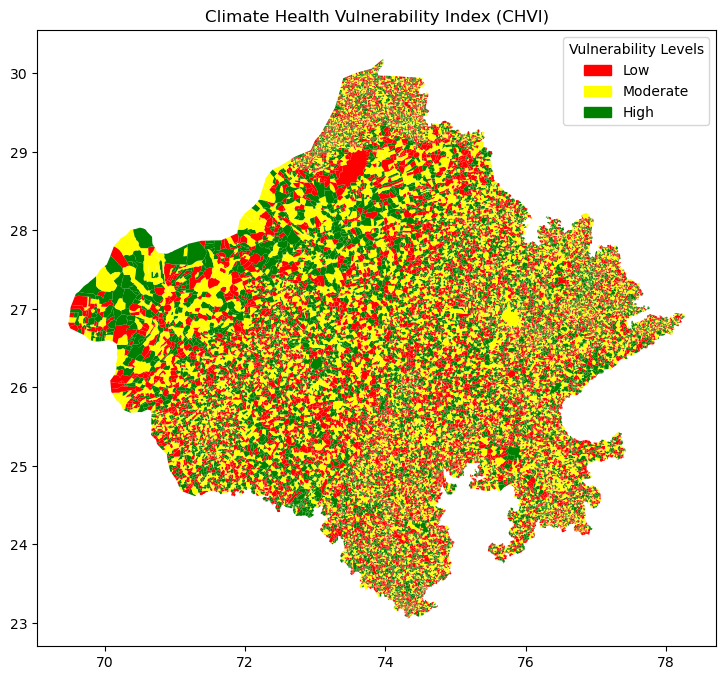

In [26]:
# Set colors for vulnerability levels
color_map = {'Low': 'red', 'Moderate': 'yellow', 'High': 'green'}
gdf['color'] = gdf['vulnerability_level'].map(color_map)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(color=gdf['color'], ax=ax, linewidth=0.1)

# Add legend
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, title="Vulnerability Levels", loc="upper right")

plt.title("Climate Health Vulnerability Index (CHVI)")
plt.show()

**Extracting CHVI Values and Rankings:**  
This snippet creates a table with the CHVI values and corresponding vulnerability levels. The table is sorted in descending order of CHVI, effectively ranking the regions from highest to lowest vulnerability, and then printed. This provides a clear overview of which regions are most at risk based on the CHVI.


In [28]:
# Extract CHVI values and their rankings
chvi_table = gdf[['CHVI', 'vulnerability_level']].sort_values(by='CHVI', ascending=False).reset_index(drop=True)
print(chvi_table)

           CHVI vulnerability_level
0      1.166719                 Low
1      1.155552                 Low
2      1.154154                 Low
3      1.126472                 Low
4      1.113271                 Low
...         ...                 ...
45035 -0.505916                High
45036 -0.522011                High
45037 -0.536289                High
45038 -0.574819                High
45039 -0.609865                High

[45040 rows x 2 columns]


<h1><b>TASK 3: MALARIA AND DENGUE HOTSPOT ANALYSIS</b></h1>

**Using Getis-Ord Gi for Malaria and Dengue Hotspots:**  
The Getis-Ord Gi* is a local spatial statistic that helps identify clusters of high (hotspots) or low (cold spots) values within geographic data. When applied to malaria and dengue incidence rates, it pinpoints areas with significantly high case counts, indicating potential hotspots. This method is crucial for public health, as it guides targeted interventions and resource allocation to mitigate disease spread.


In [60]:
df= gpd.read_file(file_path)

In [61]:
# Data preprocessing
required_columns = ['region_id', 'mean_rainfall', 'lst_day_celsius', 'malaria_cases', 'dengue_cases', 'geometry']
df = df[required_columns].dropna()
df[['dengue_cases', 'malaria_cases','mean_rainfall', 'lst_day_celsius']].describe()


dengue_cases  malaria_cases  mean_rainfall  lst_day_celsius
count  45040.000000   45040.000000   45040.000000     45040.000000
mean       7.002376       9.585546     150.433672        32.560613
std        4.385473       5.345997      86.701917         7.204992
min        0.000000       0.000000       0.003998        20.000119
25%        3.000000       5.000000      75.030790        26.339545
50%        7.000000       9.000000     150.372416        32.568282
75%       10.000000      13.000000     225.724964        38.754007
max       28.000000      33.000000     299.995565        44.999735

In [62]:
df[['dengue_cases', 'malaria_cases','mean_rainfall', 'lst_day_celsius']].head(20)


dengue_cases  malaria_cases  mean_rainfall  lst_day_celsius
0             12             15     230.871735        41.130201
1              8              8     156.343807        22.389024
2              7              9     151.891393        38.854294
3              1              6      29.600448        38.843189
4             10             19     209.939499        41.957441
5              8              8     177.241155        39.140360
6              2              1       9.273413        23.233438
7              9             14     253.572430        27.518864
8              1              5      84.354729        30.584512
9             15             11     205.764525        22.831102
10             2              4      14.385311        23.018260
11            10              9     209.772327        39.714094
12             5             16     148.966370        24.257654
13             1              1       4.195424        42.627183
14            10             11     182.101871        25.313573
15             7              2      97.078022        32.270854
16             3              6      40.253848        25.291637
17            11             13     160.012581        43.528589
18             1              2       9.639837        33.553944
19            11             10     121.273427        33.990018

**Outbreak Type Classification:**  
This code adds a new column called `outbreak_type` to the DataFrame. It checks if the number of malaria cases is higher than the number of dengue cases. If yes, it marks that row with a `1` (indicating a malaria outbreak). If not, it marks it with a `0` (indicating a dengue outbreak).


In [63]:
# Create outbreak type (1 = Malaria, 0 = Dengue)
df['outbreak_type'] = np.where(df['malaria_cases'] > df['dengue_cases'], 1, 0)

**Exploratory Data Analysis on Outbreaks:**  
This code creates a scatterplot to study how rainfall and temperature relate to malaria and dengue outbreaks. It does the following:

- **Plots Data Points:**  
  - **Malaria:** Red squares (when `outbreak_type` is 1)  
  - **Dengue:** Blue circles (when `outbreak_type` is 0)
  
- **Axes Settings:**  
  The x-axis (Mean Rainfall in mm) is set between 50 and 300, and the y-axis (Daytime Temperature in °C) is set between 25 and 45.

- **Additional Features:**  
  A subtle grid is added for better readability, and a legend is included to clearly label each outbreak type.

This helps us visually compare the environmental conditions related to each outbreak type.


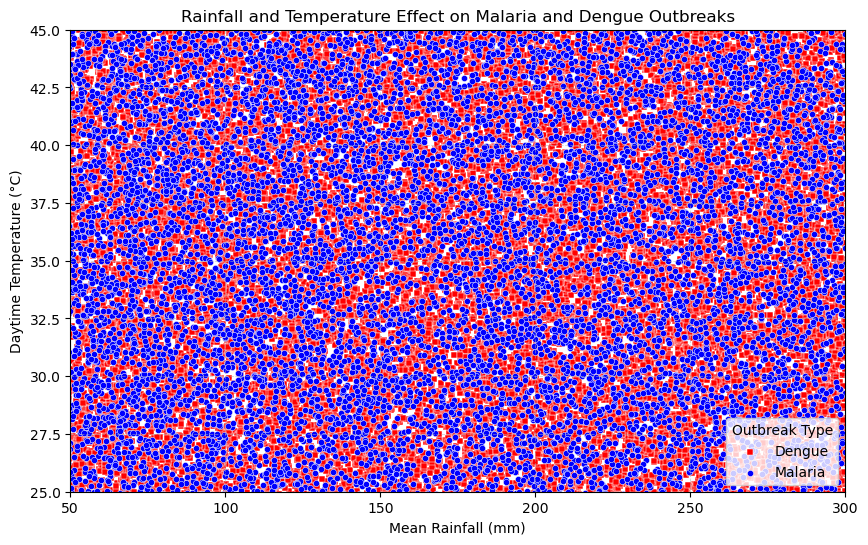

In [64]:
# Exploratory Data Analysis
plt.figure(figsize=(10, 6))

# Plot Malaria (red squares) first
sns.scatterplot(data=df[df['outbreak_type'] == 1], x='mean_rainfall', y='lst_day_celsius',
                color='red', marker='s', label='Malaria', s=20)

# Plot Dengue (blue circles) second
sns.scatterplot(data=df[df['outbreak_type'] == 0], x='mean_rainfall', y='lst_day_celsius',
                color='blue', marker='o', label='Dengue', s=20)

# Set axis limits to match the reference plot
plt.xlim(50, 300)
plt.ylim(25, 45)

# Add a subtle grid
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)

plt.title('Rainfall and Temperature Effect on Malaria and Dengue Outbreaks')
plt.xlabel('Mean Rainfall (mm)')
plt.ylabel('Daytime Temperature (°C)')

# Ensure the legend order matches the reference plot
plt.legend(title='Outbreak Type', labels=['Dengue', 'Malaria'])

plt.show()


**Logistic Regression Model Setup:**  
This code prepares the data for a logistic regression model to predict the type of outbreak (malaria or dengue). It does the following:

- **Selects Features:** Uses `mean_rainfall` and `lst_day_celsius` as the independent variables.
- **Adds an Intercept:** The `add_constant(X)` function adds a constant term to the features, which allows the model to calculate an intercept.
- **Defines the Target:** Sets `outbreak_type` as the dependent variable, where a value of 1 means malaria and 0 means dengue.


In [65]:
# Logistic Regression Model
X = df[['mean_rainfall', 'lst_day_celsius']]
X = add_constant(X)  # Add constant term for intercept
y = df['outbreak_type']

**Variance Inflation Factor (VIF) Calculation:**  
This code calculates the VIF for each feature in the logistic regression model. VIF helps us understand if any features are too similar (collinear) to each other, which might affect the model.

- A DataFrame is created to store the features and their VIF values.
- The `variance_inflation_factor` function calculates the VIF for each feature.
- Finally, the VIF values are printed out to check for multicollinearity.


In [66]:
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\n=== Variance Inflation Factor (VIF) ===\n", vif)


=== Variance Inflation Factor (VIF) ===
            Feature        VIF
0            const  24.493860
1    mean_rainfall   1.000014
2  lst_day_celsius   1.000014


**Fitting the Logistic Regression Model:**  
This code fits a logistic regression model using the selected features (mean_rainfall and lst_day_celsius) along with an intercept (added by `add_constant`). The target variable is `outbreak_type` (1 for malaria, 0 for dengue). After fitting the model with `Logit(y, X).fit()`, the summary of the model—showing coefficients, p-values, and other statistics—is printed to help assess its performance.


In [67]:
# Fit logistic regression model
logit_model = Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.613632
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          outbreak_type   No. Observations:                45040
Model:                          Logit   Df Residuals:                    45037
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Mar 2025   Pseudo R-squ.:                0.004026
Time:                        15:15:42   Log-Likelihood:                -27638.
converged:                       True   LL-Null:                       -27750.
Covariance Type:            nonrobust   LLR p-value:                 3.051e-49
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6135      0.051     12.134      0.000       0.514       0.713
mean_rainfall 

**Model Interpretation:**  
This code prints key statistics to help us understand the fitted logistic regression model:

- **Log-Likelihood:** Measures how well the model fits the data.
- **Pseudo R-squared:** Indicates the proportion of variation explained by the model.
- **Variable Coefficients:** Shows the impact of each predictor on the outcome.

These values are important for assessing model performance and interpreting the results.


In [104]:
print("\n=== Model Interpretation ===")
print("Log-Likelihood:", logit_model.llf)
print("Pseudo R-squared:", logit_model.prsquared)
print("Variable Coefficients:")
print(logit_model.params)


=== Model Interpretation ===
Log-Likelihood: -27638.002671651917
Pseudo R-squared: 0.004025670264845571
Variable Coefficients:
const              0.613522
mean_rainfall      0.001761
lst_day_celsius   -0.001732
dtype: float64


**Hypothesis Testing for Rainfall Effect:**  
This code tests whether the effect of rainfall on malaria outbreaks is statistically significant:

- It extracts the coefficient and p-value for `mean_rainfall` from the logistic regression model.
- It prints these values.
- If the p-value is less than 0.05, it concludes that rainfall has a statistically significant effect on malaria outbreaks; otherwise, it does not.

This helps determine if rainfall is an important predictor in the model.


In [105]:
# Hypothesis Testing
print("\n=== Hypothesis Testing ===")
rainfall_coef = logit_model.params['mean_rainfall']
rainfall_pvalue = logit_model.pvalues['mean_rainfall']
print(f"Rainfall Coefficient: {rainfall_coef:.4f}, P-Value: {rainfall_pvalue:.4f}")
if rainfall_pvalue < 0.05:
    print("- The effect of rainfall on malaria outbreaks is statistically significant.")
else:
    print("- No statistically significant effect of rainfall on malaria outbreaks.")


=== Hypothesis Testing ===
Rainfall Coefficient: 0.0018, P-Value: 0.0000
- The effect of rainfall on malaria outbreaks is statistically significant.


**Checking Linearity of Logit for lst_day_celsius:**  
This code checks if there's a linear relationship between the predictor `lst_day_celsius` and the log-odds (logit) of the outcome. It:

- Calculates the logit (log-odds) from the predicted probabilities.
- Creates a scatterplot with `lst_day_celsius` on the x-axis and the logit on the y-axis.
- Uses the plot to visually assess the linearity assumption for logistic regression.


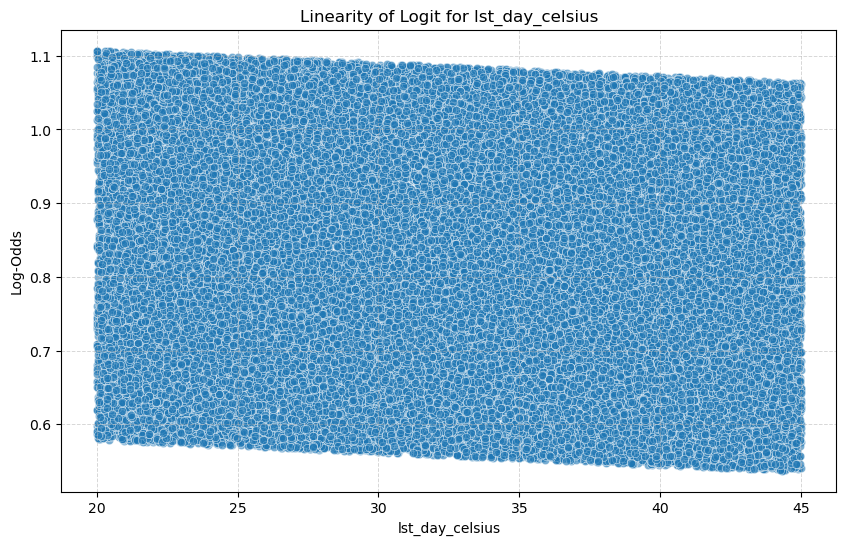

In [70]:
# Check linearity of logit for lst_day_celsius
df['logit'] = np.log(logit_model.predict(X) / (1 - logit_model.predict(X)))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['lst_day_celsius'], y=df['logit'], alpha=0.6, edgecolor='white')

plt.title('Linearity of Logit for lst_day_celsius')
plt.xlabel('lst_day_celsius')
plt.ylabel('Log-Odds')
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)

plt.show()


<h1><b>TASK 4: : Child malnutrition with soil moisture, relative humidity, and temperature </b></h1>

**ANOVA Test:**  
ANOVA (Analysis of Variance) is a statistical method used to compare the means of three or more groups. It helps determine if there are any significant differences among the group means by comparing the variance within each group to the variance between groups. A low p-value (usually less than 0.05) indicates that at least one group mean is significantly different from the others.


In [73]:
# Load GeoJSON file
gdf = gpd.read_file("climate_health_anonymized_dataset_v4.geojson")
gdf.head(3)

region_id block_code_census  population_density  rural_facilities  \
0        1.0              3151            5.861466             148.0   
1        2.0              3151            5.861466             148.0   
2        3.0              3151            5.861466             148.0   

   no2_density  co_density      ndvi  lst_day_celsius  pm25_aerosol_index  \
0     0.024982    0.430091  0.407704        41.130201           62.794769   
1     0.048029    0.300109  0.563408        22.389024           85.898111   
2     0.039280    0.207941  0.294113        38.854294          142.901821   

       ndwi  ...  tb_cases  heart_disease_cases  cancer_cases  \
0  0.302323  ...         0                   10             8   
1 -0.849127  ...         0                    8             5   
2 -0.232678  ...         0                   15            10   

   child_malnutrition_cases  maternal_anemia_cases  smoker_cases  \
0                        18                      0             3   
1                         9                      0             0   
2                        13                      0             2   

   lung_problem_cases  dengue_cases  malaria_cases  \
0                   1            12             15   
1                   1             8              8   
2                   1             7              9   

                                            geometry  
0  POLYGON ((74.33266 23.07299, 74.33477 23.07139...  
1  POLYGON ((74.34126 23.08345, 74.34021 23.0819,...  
2  POLYGON ((74.34524 23.0842, 74.34808 23.08415,...  

[3 rows x 32 columns]

**Data Cleaning and Preparation:**  
- **Select Columns:** The code selects only the necessary columns from the GeoDataFrame (`gdf`) that are needed for the analysis.  
- **Check Missing Values:** It prints the number of missing values in each column to identify any data issues.  
- **Drop Missing Data:** Rows with missing values are removed to ensure a clean dataset for further analysis.


In [74]:
# Selecting only necessary columns
df = gdf[['region_id', 'child_malnutrition_cases', 'soil_moisture', 'relative_humidity', 'lst_day_celsius', 'geometry']]

# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values (or use imputation if needed)
df = df.dropna()

region_id                   0
child_malnutrition_cases    0
soil_moisture               0
relative_humidity           0
lst_day_celsius             0
geometry                    0
dtype: int64


In [75]:
print(df['child_malnutrition_cases'].describe())


count    45040.000000
mean        10.531505
std          6.881444
min          0.000000
25%          5.000000
50%         10.000000
75%         16.000000
max         37.000000
Name: child_malnutrition_cases, dtype: float64


**Scaling and Visualizing Relationships:**  
- **Scaling:**  
  The `child_malnutrition_cases` variable is linearly transformed to a new range [20, 120]. This helps standardize the data for better comparison in plots.
  
- **Jitter Function:**  
  A jitter function is defined to add a small random noise to the data points. This prevents points from overlapping in scatter plots.
  
- **Scatter Plots:**  
  Three scatter plots are created to explore the relationship between scaled child malnutrition cases and:
  1. Soil Moisture
  2. Relative Humidity
  3. Daytime Temperature (lst_day_celsius)
  
  Each plot includes customized axis labels, titles, and tick marks for clarity. The plots are arranged neatly using `plt.tight_layout()`.


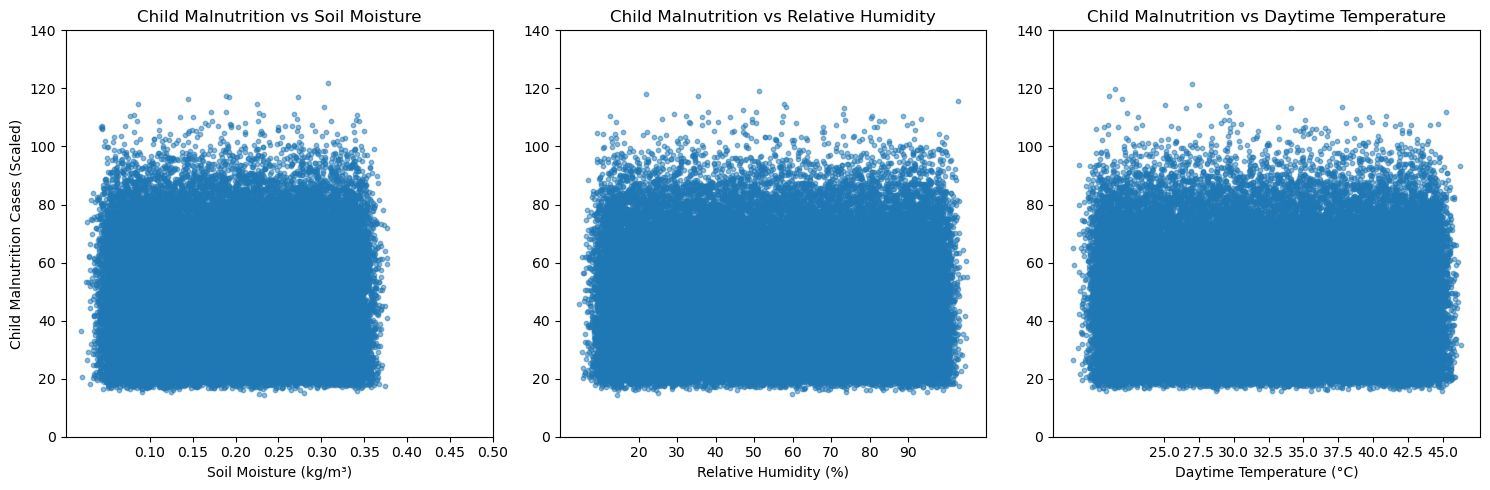

In [76]:

# Scaling function: Linear transformation from [min, max] to [20, 120]
y_min, y_max = df['child_malnutrition_cases'].min(), df['child_malnutrition_cases'].max()
df['child_malnutrition_cases_scaled'] = 20+ ((df['child_malnutrition_cases'] - y_min) / (y_max - y_min)) * (100)

# Jitter function
def jitter(values, scale=0.5):
    return values + np.random.normal(scale=scale, size=len(values))

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Soil Moisture vs Child Malnutrition
axes[0].scatter(jitter(df['soil_moisture'], 0.01), jitter(df['child_malnutrition_cases_scaled'], 1.5), 
                alpha=0.5, s=10)
axes[0].set_xlabel("Soil Moisture (kg/m³)")
axes[0].set_ylabel("Child Malnutrition Cases (Scaled)")
axes[0].set_title("Child Malnutrition vs Soil Moisture")
axes[0].set_xticks(np.arange(0.10, 0.55, 0.05))
axes[0].set_ylim(0, 140)

# Relative Humidity vs Child Malnutrition
axes[1].scatter(jitter(df['relative_humidity'], 2), jitter(df['child_malnutrition_cases_scaled'], 1.5), 
                alpha=0.5, s=10)
axes[1].set_xlabel("Relative Humidity (%)")
axes[1].set_title("Child Malnutrition vs Relative Humidity")
axes[1].set_xticks(np.arange(20, 100, 10))
axes[1].set_ylim(0, 140)

# Daytime Temperature vs Child Malnutrition
axes[2].scatter(jitter(df['lst_day_celsius'], 0.5), jitter(df['child_malnutrition_cases_scaled'], 1.5), 
                alpha=0.5, s=10)
axes[2].set_xlabel("Daytime Temperature (°C)")
axes[2].set_title("Child Malnutrition vs Daytime Temperature")
axes[2].set_xticks(np.arange(25.0, 47.5, 2.5))
axes[2].set_ylim(0, 140)

plt.tight_layout()
plt.show()


**OLS Regression Model Setup:**  
- **Variables:**  
  - **Dependent Variable:** `child_malnutrition_cases`  
  - **Independent Variables:** `soil_moisture`, `relative_humidity`, and `lst_day_celsius`
- **Intercept:** A constant is added to the independent variables to include an intercept in the model.
- **Model Fitting:** The Ordinary Least Squares (OLS) regression model is fitted using these variables.
- **Output:** The model summary, which includes coefficients, p-values, and other statistics, is printed.


In [77]:
# Define independent and dependent variables
X = df[['soil_moisture', 'relative_humidity', 'lst_day_celsius']]
y = df['child_malnutrition_cases']

# Add constant for intercept
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                               OLS Regression Results                               
Dep. Variable:     child_malnutrition_cases   R-squared:                       0.000
Model:                                  OLS   Adj. R-squared:                 -0.000
Method:                       Least Squares   F-statistic:                    0.1959
Date:                      Sun, 16 Mar 2025   Prob (F-statistic):              0.899
Time:                              15:18:59   Log-Likelihood:            -1.5078e+05
No. Observations:                     45040   AIC:                         3.016e+05
Df Residuals:                         45036   BIC:                         3.016e+05
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

**Performing ANOVA on a Regression Model:**  
- A regression model is created using the formula:  
  `child_malnutrition_cases ~ soil_moisture + relative_humidity + lst_day_celsius`  
  This means we're trying to explain the variation in child malnutrition cases using soil moisture, relative humidity, and daytime temperature.

- The model is fitted using `smf.ols()`, which performs an Ordinary Least Squares regression.

- ANOVA (Analysis of Variance) is then applied to the fitted model with `sm.stats.anova_lm()`.  
  This test checks if the independent variables significantly explain the variation in the dependent variable by comparing the variance between groups.

- The output includes F-statistics and p-values, which help determine if each factor has a significant effect.


In [78]:
# Example: Suppose df has columns 'child_malnutrition_cases', 'soil_moisture', 'relative_humidity', 'lst_day_celsius'
formula = "child_malnutrition_cases ~ soil_moisture + relative_humidity + lst_day_celsius"
model = smf.ols(formula=formula, data=df).fit()  # Fit the model

# Now perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

                         sum_sq       df         F    PR(>F)
soil_moisture      8.306148e+00      1.0  0.175395  0.675363
relative_humidity  7.111941e+00      1.0  0.150178  0.698367
lst_day_celsius    1.246205e+01      1.0  0.263152  0.607965
Residual           2.132761e+06  45036.0       NaN       NaN


**Geospatial Visualization of Child Malnutrition Cases:**
- **Scaling:**  
  The child malnutrition cases are scaled using Min-Max normalization to a range of 20 to 120. This standardizes the data for a better visual comparison.

- **Plotting:**  
  The GeoDataFrame is plotted using the `Reds` colormap. Regions with higher scaled values appear in deeper red. Black edges and a thin linewidth help distinguish the boundaries.

- **Legend and Title:**  
  A vertical legend is added to show the color scale for child malnutrition cases, and the plot is titled for clarity.

This map visually represents the spatial distribution of child malnutrition, highlighting areas with varying levels of cases.


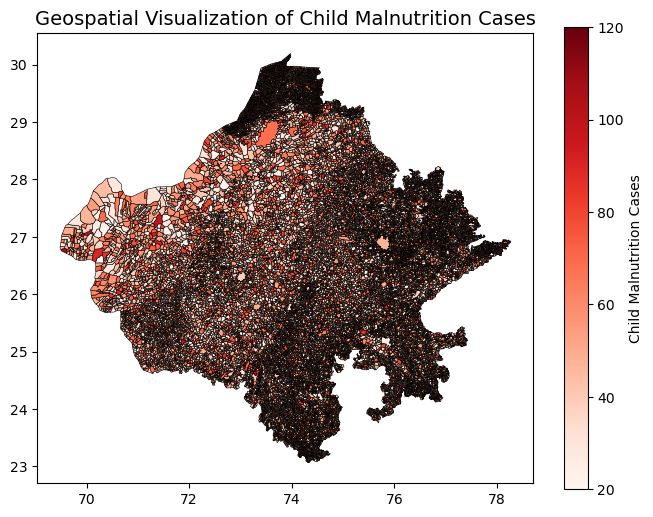

In [79]:
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify as mc  # For classification schemes

# Perform Min-Max Scaling (20 to 120)
gdf['scaled_malnutrition'] = 20 + (gdf['child_malnutrition_cases'] - 0) * (120 - 20) / (37 - 0)

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Adjust figure size

# Plot geospatial data
gdf.plot(column='scaled_malnutrition', 
         cmap='Reds',  # Better colormap
         edgecolor='black', 
         linewidth=0.4, 
         legend=True,  # Enable color bar
         legend_kwds={'label': "Child Malnutrition Cases",  # Label for color bar
                      'orientation': "vertical"},  # Make it vertical
         ax=ax)

# Title
ax.set_title("Geospatial Visualization of Child Malnutrition Cases", fontsize=14)

plt.show()


**Analyzing Regression Residuals:**  
- **Model Fitting:** We build a regression model using `child_malnutrition_cases` as the outcome and `soil_moisture`, `relative_humidity`, and `lst_day_celsius` as predictors.  
- **Residuals Calculation:** The residuals (actual minus predicted values) are computed from the model.  
- **Histogram Plot:** A histogram with a KDE curve is created to visualize how these residuals are distributed.  
- **Purpose:** This helps us check if the residuals are normally distributed, which is important for confirming that the model's assumptions are met.


C:\Users\SHALVI_SINGH\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


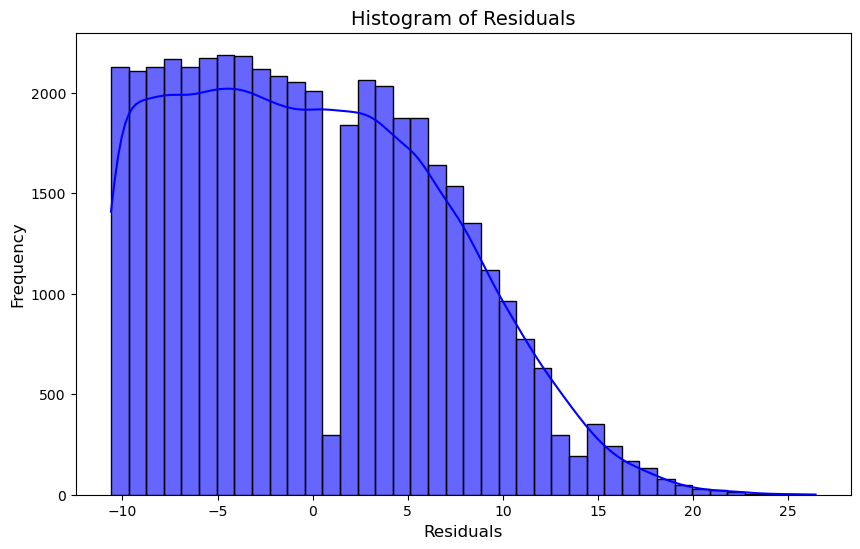

In [80]:
# Example: Suppose df contains the dataset
formula = "child_malnutrition_cases ~ soil_moisture + relative_humidity + lst_day_celsius"
model = smf.ols(formula=formula, data=df).fit()  # Fit the regression model

# Get residuals
residuals = model.resid  # Actual - Predicted

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=40, kde=True, color="blue", edgecolor="black", alpha=0.6)  # KDE for smooth curve

# Labels and title
plt.title("Histogram of Residuals", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show plot
plt.show()

**Residuals vs. Fitted Values Plot:**  
- **Model Fitting:** We fit an OLS regression model with `child_malnutrition_cases` as the outcome and `soil_moisture`, `relative_humidity`, and `lst_day_celsius` as predictors.  
- **Fitted Values:** The model's predictions (fitted values) are extracted to see what the model estimates for each observation.  
- **Residuals:** The residuals (the differences between the actual and predicted values) are calculated.  
- **Scatter Plot:** A scatter plot is created with fitted values on the x-axis and residuals on the y-axis.  
- **Reference Line:** A horizontal dashed red line at y=0 is added to help check if residuals are evenly scattered around zero.  
- **Purpose:** This plot is used to detect any patterns or issues (like non-linearity or unequal variance) that might suggest problems with the model.


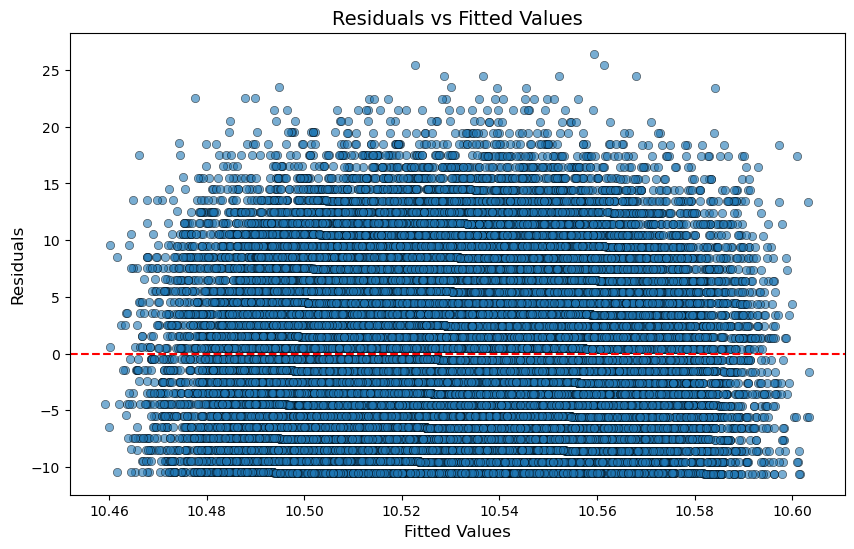

In [81]:
# Fit the regression model
formula = "child_malnutrition_cases ~ soil_moisture + relative_humidity + lst_day_celsius"
model = smf.ols(formula=formula, data=df).fit()

# Get fitted values (predictions)
fitted_values = model.fittedvalues

# Get residuals
residuals = model.resid

# Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals, edgecolor="black", alpha=0.6)

# Add a horizontal line at y=0
plt.axhline(y=0, color="red", linestyle="dashed")

# Labels and title
plt.title("Residuals vs Fitted Values", fontsize=14)
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)

# Show plot
plt.show()

<h1><b>TASK 5: Tuberculosis and Population Density</b></h1>

**Impact of Population Density and Rural Facilities on TB Cases:**  
- **Population Density:** Areas with high population density tend to have more TB cases because people live closer together, which can increase the risk of TB spreading through the air.  
- **Rural Facilities:** In rural areas, the availability and quality of healthcare facilities can greatly influence TB outcomes. Limited resources and delayed treatment in rural settings may lead to higher TB case numbers, while better-equipped facilities can help reduce the spread and severity of the disease.


In [82]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45040 entries, 0 to 45039
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   region_id                 45040 non-null  float64 
 1   block_code_census         45040 non-null  object  
 2   population_density        45040 non-null  float64 
 3   rural_facilities          45040 non-null  float64 
 4   no2_density               45040 non-null  float64 
 5   co_density                45040 non-null  float64 
 6   ndvi                      45040 non-null  float64 
 7   lst_day_celsius           45040 non-null  float64 
 8   pm25_aerosol_index        45040 non-null  float64 
 9   ndwi                      45040 non-null  float64 
 10  spi                       45040 non-null  float64 
 11  relative_humidity         45040 non-null  float64 
 12  solar_radiation           45040 non-null  float64 
 13  spei                      45040 non-nu

In [83]:
gdf.isnull().sum()

region_id                   0
block_code_census           0
population_density          0
rural_facilities            0
no2_density                 0
co_density                  0
ndvi                        0
lst_day_celsius             0
pm25_aerosol_index          0
ndwi                        0
spi                         0
relative_humidity           0
solar_radiation             0
spei                        0
lst_night_celsius           0
uv_index                    0
soil_moisture               0
so2_density                 0
water_extent_area_m2        0
air_temperature             0
dew_point_temperature       0
mean_rainfall               0
tb_cases                    0
heart_disease_cases         0
cancer_cases                0
child_malnutrition_cases    0
maternal_anemia_cases       0
smoker_cases                0
lung_problem_cases          0
dengue_cases                0
malaria_cases               0
geometry                    0
scaled_malnutrition         0
dtype: int

**Data Cleaning for Regression Analysis:**  
- **Selecting Columns:**  
  The code defines a list of required columns for regression: `"tb_cases"`, `"population_density"`, `"rural_facilities"`, `"co_density"`, and `"geometry"`.
  
- **Removing Missing Values:**  
  Rows with missing data in any of these columns are dropped to ensure a complete dataset for analysis.
  
- **Previewing Data:**  
  The first few rows of the cleaned dataset are displayed with `gdf.head()` to verify the cleaning process.


In [84]:
# Define required columns for regression
required_columns = [
    "tb_cases", "population_density", "rural_facilities",
    "co_density", "geometry"
]

# Drop missing values
gdf = gdf.dropna(subset=required_columns)

# Display dataset after cleaning
gdf.head()


region_id block_code_census  population_density  rural_facilities  \
0        1.0              3151            5.861466             148.0   
1        2.0              3151            5.861466             148.0   
2        3.0              3151            5.861466             148.0   
3        4.0              3151            5.861466             148.0   
4        5.0              3151            5.861466             148.0   

   no2_density  co_density      ndvi  lst_day_celsius  pm25_aerosol_index  \
0     0.024982    0.430091  0.407704        41.130201           62.794769   
1     0.048029    0.300109  0.563408        22.389024           85.898111   
2     0.039280    0.207941  0.294113        38.854294          142.901821   
3     0.033946    0.348282  0.431270        38.843189          132.117802   
4     0.016241    0.482825  0.455907        41.957441           74.133445   

       ndwi  ...  heart_disease_cases  cancer_cases  child_malnutrition_cases  \
0  0.302323  ...                   10             8                        18   
1 -0.849127  ...                    8             5                         9   
2 -0.232678  ...                   15            10                        13   
3  0.323508  ...                    8             8                         2   
4 -0.514042  ...                   19             5                        22   

   maternal_anemia_cases  smoker_cases  lung_problem_cases  dengue_cases  \
0                      0             3                   1            12   
1                      0             0                   1             8   
2                      0             2                   1             7   
3                      0             4                   1             1   
4                      0             4                   6            10   

   malaria_cases                                           geometry  \
0             15  POLYGON ((74.33266 23.07299, 74.33477 23.07139...   
1              8  POLYGON ((74.34126 23.08345, 74.34021 23.0819,...   
2              9  POLYGON ((74.34524 23.0842, 74.34808 23.08415,...   
3              6  POLYGON ((74.36026 23.09077, 74.36011 23.09064...   
4             19  POLYGON ((74.34161 23.09282, 74.34224 23.09177...   

   scaled_malnutrition  
0            68.648649  
1            44.324324  
2            55.135135  
3            25.405405  
4            79.459459  

[5 rows x 33 columns]

**Negative Binomial Regression for TB Cases:**  
- **Predictors:** The independent variables are `population_density`, `rural_facilities`, and `co_density`.  
- **Intercept:** An intercept term is added using `sm.add_constant(X)`.  
- **Dependent Variable:** The outcome being modeled is `tb_cases`.  
- **Model Fitting:** A Negative Binomial regression is used (via `sm.GLM` with the NegativeBinomial family), which is suitable for count data like TB cases that may exhibit overdispersion.


In [85]:
import statsmodels.api as sm

# Define independent variables (predictors)
X = gdf[['population_density', 'rural_facilities', 'co_density']]
X = sm.add_constant(X)  # Add intercept term

# Define dependent variable (TB cases)
y = gdf['tb_cases']

# Fit Negative Binomial Regression Model
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()


C:\Users\SHALVI_SINGH\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


**Regression Model Summary:**  
The code prints the summary of the Negative Binomial regression model. This summary includes important statistics such as coefficient estimates, standard errors, z-scores, p-values, and overall fit metrics. These details help us understand how well the predictors (population density, rural facilities, and co_density) explain the variation in TB cases.


In [86]:
# Show summary of regression model
nb_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               tb_cases   No. Observations:                45040
Model:                            GLM   Df Residuals:                    45036
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9658.5
Date:                Sun, 16 Mar 2025   Deviance:                       12611.
Time:                        15:22:14   Pearson chi2:                 4.27e+04
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0008736
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.8385      0.185    -20.773      0.000      -4.201      -3.476
population_density     0.1900      0.031      6.149      0.000       0.129       0.251
rural_facilities      -0.0002      0.000     -0.598      0.550      -0.001       0.001
co_density            -0.1387      0.180     -0.772      0.440      -0.491       0.213
======================================================================================
"""

**Spatial Autocorrelation Analysis using Moran's I:**

- **Weight Matrix Creation:**  
  A spatial weight matrix is built using the 5 nearest neighbors (KNN) from the dataset. This matrix helps define which regions are considered neighbors. The weights are row-standardized (each row sums to 1).

- **Moran's I Calculation:**  
  Moran's I is computed on the `tb_cases` variable to measure spatial autocorrelation. This statistic tells us whether TB cases are clustered, dispersed, or randomly distributed across space.

- **Output:**  
  The calculated Moran's I value and its p-value are printed. A low p-value suggests that the observed spatial pattern is statistically significant.


In [87]:
from libpysal.weights import KNN
from esda.moran import Moran

# Create a spatial weight matrix using 5 nearest neighbors (KNN)
w = KNN.from_dataframe(gdf, k=5)
w.transform = 'r'  # Row standardization

# Compute Moran’s I
moran = Moran(gdf['tb_cases'], w)

# Print Moran’s I and P-value
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")


Moran's I: 0.0003539930283721069
P-value: 0.47


**Interpreting Spatial Autocorrelation and Policy Recommendations:**  
- The code checks if the p-value from Moran’s I (`moran.p_sim`) is below 0.05, which would indicate significant spatial clustering of TB cases.
- **If Significant:**  
  It prints a message stating that TB cases are spatially correlated and suggests targeted interventions such as focusing on high-risk regions, increasing healthcare facilities in clustered areas, and deploying mobile clinics.
- **If Not Significant:**  
  It indicates that TB cases are randomly distributed and recommends general public health policies and uniformly improving access to healthcare services.


In [88]:
if moran.p_sim < 0.05:
    print("\nSignificant spatial clustering detected. TB cases are spatially correlated.")
    print("Policy Recommendations:")
    print("- Focus interventions in high-risk regions.")
    print("- Increase healthcare facilities in clustered regions.")
    print("- Deploy mobile clinics to hotspot areas.")
else:
    print("\nNo significant spatial clustering detected. TB cases are randomly distributed.")
    print("Policy Recommendations:")
    print("- Implement general public health policies.")
    print("- Improve access to healthcare services uniformly.")



No significant spatial clustering detected. TB cases are randomly distributed.
Policy Recommendations:
- Implement general public health policies.
- Improve access to healthcare services uniformly.


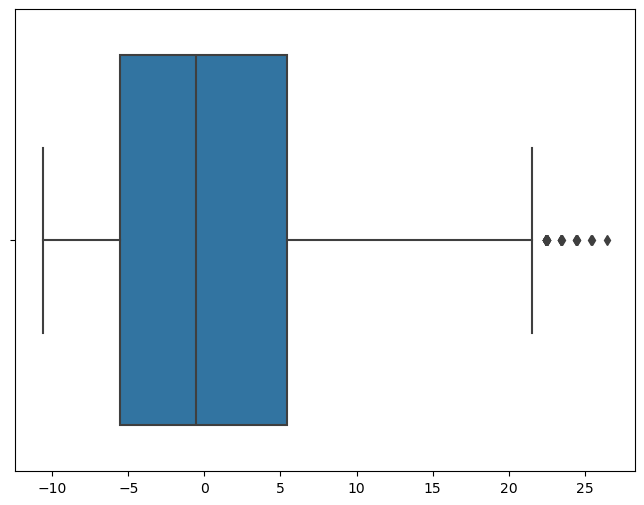

In [89]:
plt.figure(figsize=(8,6))
sns.boxplot(x=residuals)
plt.show()


In [90]:
import numpy as np

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)

# Compute the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = (residuals < lower_bound) | (residuals > upper_bound)

# Count number of outliers
print(f"Number of outliers: {outliers.sum()}")


Number of outliers: 28


**Histogram of Residuals for the Negative Binomial Model:**  
- **Residuals Calculation:**  
  The residuals are computed as the difference between the observed TB cases (`y`) and the model's fitted values.  
- **Visualization:**  
  A histogram with 50 bins is plotted to show the distribution of these residuals, along with a KDE curve to smooth out the distribution.
- **Plot Customization:**  
  The plot is titled "Histogram of Residuals" and includes axis labels and grid lines for clarity.
- **Purpose:**  
  This helps in checking whether the residuals are randomly distributed, which is crucial for validating the model's assumptions.


C:\Users\SHALVI_SINGH\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


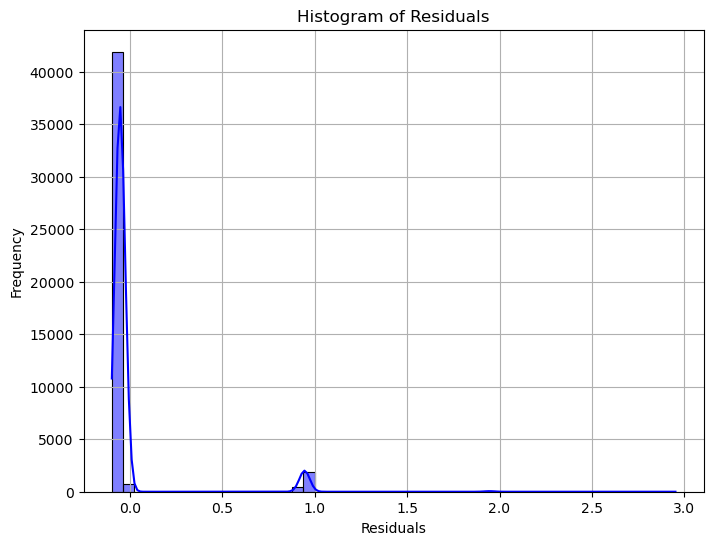

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute residuals (observed - predicted)
residuals = y - nb_model.fittedvalues

# Plot histogram of residuals
plt.figure(figsize=(8, 6))

sns.histplot(residuals, bins=50, kde=True, color='blue', edgecolor='black', alpha=0.5)

# Customize plot
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)

# Show plot
plt.show()

**Residuals vs. Fitted Values Plot:**  
- This code creates a scatter plot with the fitted values from the Negative Binomial model on the x-axis and the residuals on the y-axis.  
- A horizontal dashed red line at y=0 is added as a reference to easily see if residuals are centered around zero.  
- The y-axis limits are adjusted to ensure that all residual values are visible.  
- This plot helps check if the residuals are randomly distributed, which is important for validating the model's assumptions.


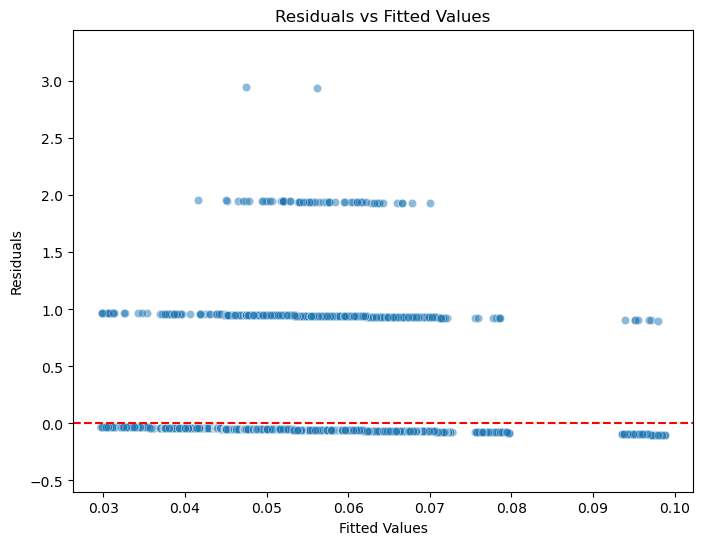

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot residuals vs fitted values
plt.figure(figsize=(8,6))
sns.scatterplot(x=nb_model.fittedvalues, y=residuals, alpha=0.5)  # Set transparency to 0.5 for visibility

# Add a horizontal reference line at y = 0
plt.axhline(y=0, color='red', linestyle='dashed')

# Adjust Y-axis limits for better visibility
plt.ylim(residuals.min() - 0.5, residuals.max() + 0.5)

# Add labels and title
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")

# Show the plot
plt.show()
